# Gradient boost decision tree (XGboost) for firewall data anomally detection

In [1]:
# Import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
sns.set(font="Verdana")
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('firewall.csv')

In [3]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [4]:
# Check size
df.shape

(65532, 12)

In [5]:
# Check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [6]:
# Check statistics 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Source Port,65532.0,49391.969343,1.525571e+04,0.0,49183.0,53776.5,58638.00,6.553400e+04
Destination Port,65532.0,10577.385812,1.846603e+04,0.0,80.0,445.0,15000.00,6.553500e+04
NAT Source Port,65532.0,19282.972761,2.197069e+04,0.0,0.0,8820.5,38366.25,6.553500e+04
NAT Destination Port,65532.0,2671.049930,9.739162e+03,0.0,0.0,53.0,443.00,6.553500e+04
Bytes,65532.0,97123.950085,5.618439e+06,60.0,66.0,168.0,752.25,1.269359e+09
Bytes Sent,65532.0,22385.796908,3.828139e+06,60.0,66.0,90.0,210.00,9.484772e+08
Bytes Received,65532.0,74738.153177,2.463208e+06,0.0,0.0,79.0,449.00,3.208818e+08
Packets,65532.0,102.866035,5.133002e+03,1.0,1.0,2.0,6.00,1.036116e+06
Elapsed Time (sec),65532.0,65.833577,3.024618e+02,0.0,0.0,15.0,30.00,1.082400e+04
pkts_sent,65532.0,41.399530,3.218871e+03,1.0,1.0,1.0,3.00,7.475200e+05



## Check missing data and duplications

In [7]:
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [8]:
df.duplicated().sum()

8362

In [9]:
df.drop_duplicates(inplace = True)

In [10]:
df.duplicated().sum()

0

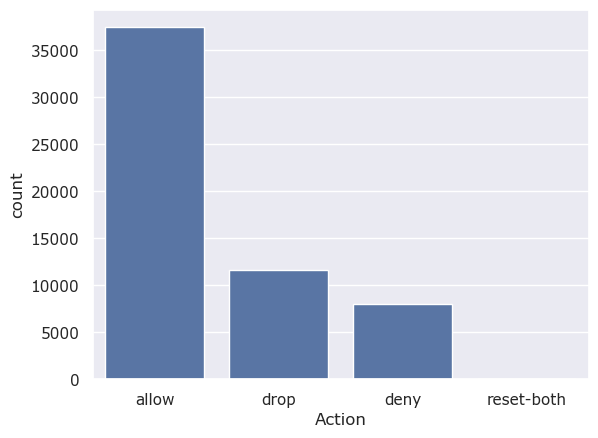

In [11]:
# Visualization
sns.countplot(data = df, x = 'Action')
plt.show()


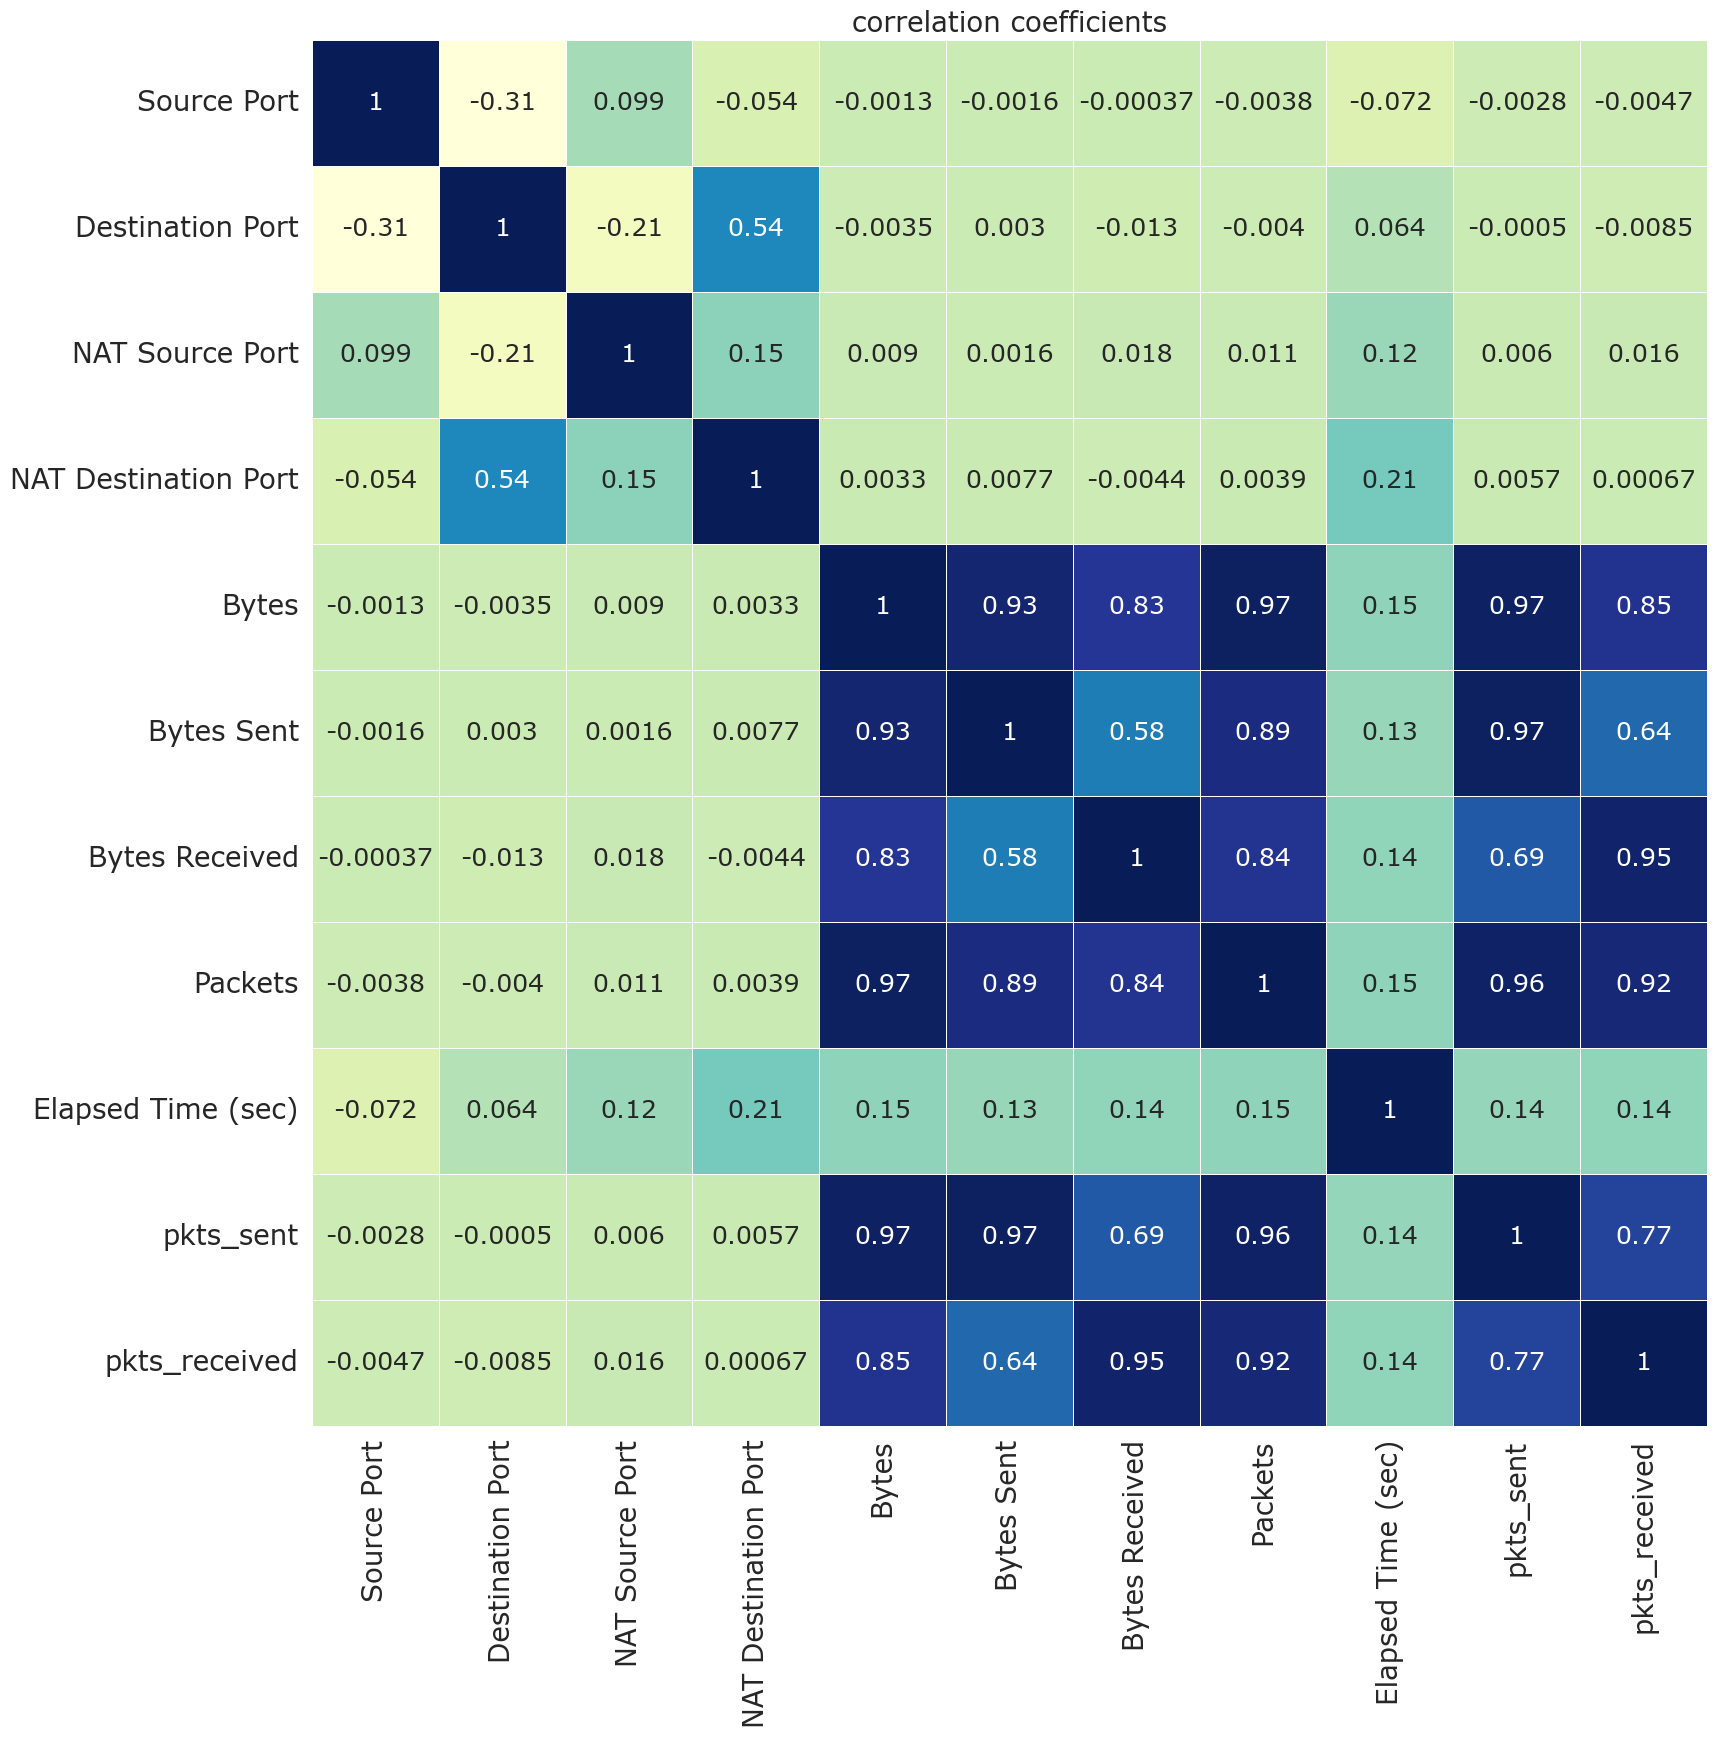

In [12]:
fig = plt.figure(figsize = (18, 18))
sns.heatmap(df.corr(numeric_only=True), vmax = 1, annot = True, linewidths = 0.5, 
            cbar = False, cmap = 'YlGnBu', annot_kws = {'fontsize' : 18})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('correlation coefficients', fontsize = 20) 
plt.show()

### Feature Engineering

In [13]:
df['Action'].value_counts()

allow         37439
drop          11635
deny           8042
reset-both       54
Name: Action, dtype: int64

In [14]:
df['Action'].replace(to_replace = {'allow' : 0, 'drop' : 1, 'deny' : 2, 
                                   'reset-both' : 3}, inplace = True)

In [15]:
df['Action'].value_counts()

0    37439
1    11635
2     8042
3       54
Name: Action, dtype: int64

### Prepare Data for modeling

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X = df.drop('Action', axis = 1)

In [18]:
y = df["Action"]

In [19]:
# Divide data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42)
print('Training size:', X_train.shape[0])
print('Testing size:', X_test.shape[0])      

Training size: 45736
Testing size: 11434


In [20]:
# Constructing logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Logistic Regression accuracy: ', lr.score(X_test, y_test))

Logistic Regression accuracy:  0.9814588070666433


In [21]:
# Constructing KNN model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

neigh = 3

knn = KNeighborsClassifier(n_neighbors = neigh)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print('K Nearest Neighbors: ', knn.score(X_test,y_test))

K Nearest Neighbors:  0.9936155326220045


Decision Tree:  0.9925660311352108


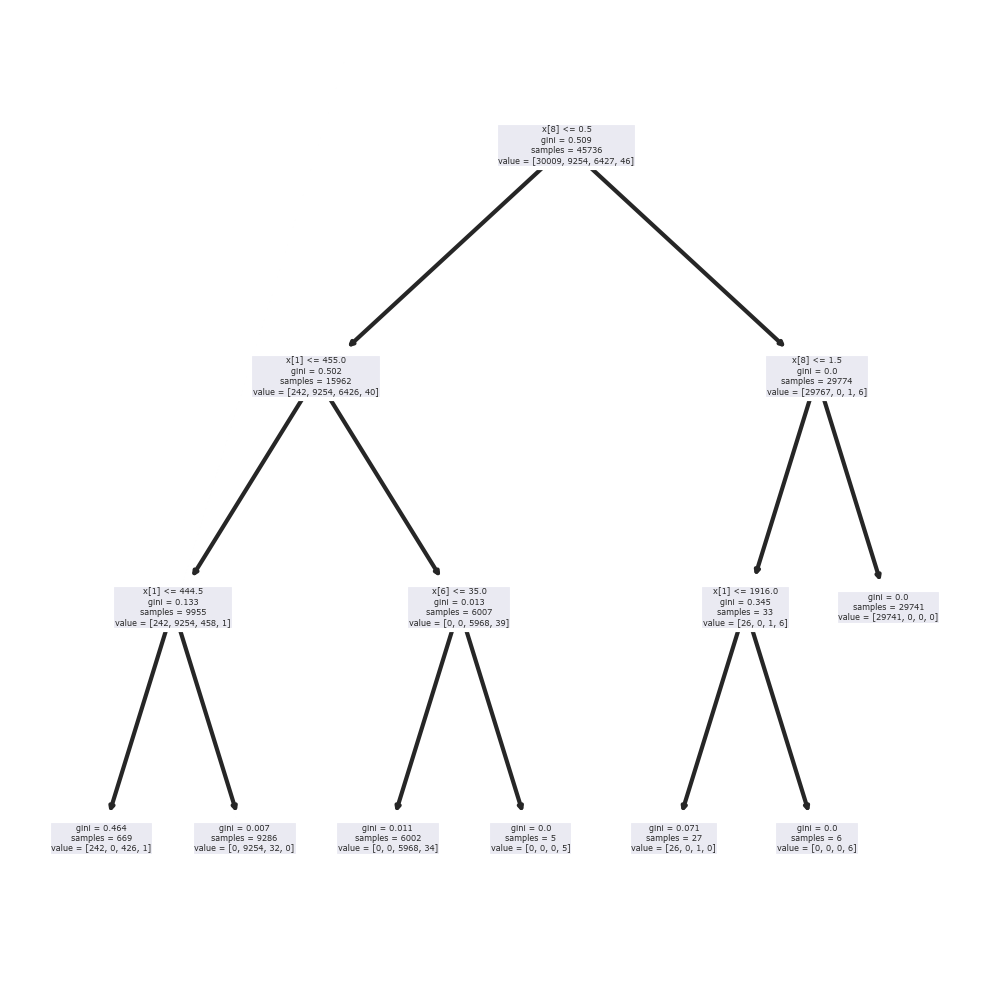

In [22]:
# Constructing and visualize a decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

max_depth = 3

dtc = DecisionTreeClassifier(max_depth = max_depth)
dtc.fit(X_train,y_train)
print('Decision Tree: ', dtc.score(X_test,y_test))

# plot the tree
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
tree.plot_tree(dtc);

In [23]:
# Constructing a lightGBM model
from lightgbm import LGBMClassifier
boosting_type = 'gbdt'


lgbm = LGBMClassifier(boosting_type = boosting_type)
lgbm.fit(X_train,y_train)

print("Light GBM Classifier: ", lgbm.score(X_test,y_test))

  File "C:\Users\tyler\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\tyler\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tyler\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\tyler\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 45736, number of used features: 11
[LightGBM] [Info] Start training from score -0.421388
[LightGBM] [Info] Start training from score -1.597830
[LightGBM] [Info] Start training from score -1.962378
[LightGBM] [Info] Start training from score -6.902000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Light GBM Classifier:  0.9983382893125765


In [34]:
# Constructing XGboost model
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)

print('XGBoost Classifier Accuracy %.4f' % xgb.score(X_test,y_test))

XGBoost Classifier Accuracy 0.9986


In [35]:
# Model assessment/evaluation
from sklearn.metrics import r2_score, confusion_matrix, classification_report, auc, roc_curve
y_pred = xgb.predict(X_test)
print('Model R2: ', r2_score(y_test, y_pred))
print('Model Confusion Matrix: ','\n', confusion_matrix(y_test,y_pred))
print('Model classification report: ','\n', classification_report(y_test,y_pred))

Model R2:  0.9969034757638603
Model Confusion Matrix:  
 [[7430    0    0    0]
 [   0 2381    0    0]
 [   1    7 1606    1]
 [   0    0    7    1]]
Model classification report:  
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7430
           1       1.00      1.00      1.00      2381
           2       1.00      0.99      1.00      1615
           3       0.50      0.12      0.20         8

    accuracy                           1.00     11434
   macro avg       0.87      0.78      0.80     11434
weighted avg       1.00      1.00      1.00     11434



In [26]:
# Confusion matrix visualization
fig = plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,y_pred),vmax = 1, annot = True)
                 

In [36]:
# print feature importance score
feat_labels = X_train.columns[0:]
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
index_list = []
value_list = []
for f,j in zip(range(X_train.shape[1]), indices):
    index_list.append(feat_labels[j])
    value_list.append(importances[j])
    print(f + 1, feat_labels[j], importances[j])


1 Elapsed Time (sec) 0.8470162
2 Destination Port 0.05523613
3 Bytes 0.045818143
4 Packets 0.039385244
5 NAT Destination Port 0.005281363
6 pkts_sent 0.0033125912
7 NAT Source Port 0.001968568
8 Bytes Received 0.000952969
9 pkts_received 0.00040827206
10 Bytes Sent 0.00035286695
11 Source Port 0.00026755093
